In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
import os
# Use PrettyTensor to simplify Neural Network construction.
#import prettytensor as pt

In [2]:
import cifar10

ModuleNotFoundError: No module named 'cifar10'

In [ ]:
# cifar10.data_path = "data/CIFAR-10/"

In [ ]:
cifar10.maybe_download_and_extract()

Load the class-names.

In [ ]:
class_names = cifar10.load_class_names()
class_names

Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [ ]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Load the test-set.

In [ ]:
images_test, cls_test, labels_test = cifar10.load_test_data()

The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [ ]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

In [ ]:
from cifar10 import img_size, num_channels, num_classes
print("Image size:" , img_size)
print("Number of channels:" , num_channels)
print("Number of classes:" , num_classes)

In [11]:
def var(name, shape, init=None, std=None):
    if init is None:
        if std is None:
            std = (2./shape[0])**0.5
        init = tf.truncated_normal_initializer(stddev=std)
    return tf.get_variable(name=name, shape=shape, 
                           dtype=tf.float32, initializer=init)

def conv(X, f, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(X, f, strides, padding)

def max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    return tf.nn.max_pool(X, ksize, strides, padding)

In [12]:
g = tf.Graph()
with g.as_default():
    X = tf.placeholder(dtype=tf.float32, shape=[None, img_size,img_size,num_channels], name='x')
    
    Y = tf.placeholder(dtype=tf.float32, shape=[None, num_classes], name='y_true')
    I = tf.reshape(X, [-1, img_size,img_size, num_channels])
    
    
    #Conv Layer 1
    W1 = var('W1', [5,5, 3, 64])
    b1 = var('b1', [64])
    out1 = tf.nn.relu(conv(I, W1) + b1)
    out1 = max_pool(out1)
    
    #Conv Layer 2
    W2 = var('W2', [5,5, 64, 128])
    b2 = var('b2', [128])
    out2 = tf.nn.relu(conv(out1, W2) + b2)
    out2 = max_pool(out2)
    
    #Conv Layer 3
    W3 = var('W3', [5,5, 128, 256])
    b3 = var('b3', [256])
    out3 = tf.nn.relu(conv(out2, W3) + b3)
    out3 = max_pool(out3)
    
    #Conv Layer 4
    W4 = var('W4', [5,5, 256, 128])
    b4 = var('b4', [128])
    out4 = tf.nn.relu(conv(out3, W4) + b4)
    out4 = max_pool(out4)
    
    
    
    flatten = tf.reshape(out4, [-1, 2*2*128])
    
    #Fully Connected Layer
    W5 = var('W5',[2*2*128, 128])
    b5 = var('b5',[128])
    out5 = tf.nn.relu( tf.matmul(flatten ,W5) + b5 )
    
    W6 = var('W6',[128, 256])
    b6 = var('b6',[256])
    out6 = tf.nn.relu( tf.matmul(out5 ,W6) + b6 )
    
    # Output layer
    W7 = var('W7',[256,10])
    b7 = var('b7',[10])
    logits = tf.matmul(out6, W7) + b7
    
    
    
    pred = tf.argmax(logits, axis=1)
    truth = tf.argmax(Y, axis=1)
    acc = tf.reduce_mean(
    tf.cast(tf.equal(pred,truth),tf.float32))
    
    s_loss = tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y)
    loss = tf.reduce_mean(s_loss)
    
    weights = tf.trainable_variables()
    
    #l2_regularizer = tf.nn.l2_loss(weights)
    l2_regularizer =  tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4)+ tf.nn.l2_loss(W5)+ tf.nn.l2_loss(W6) + tf.nn.l2_loss(W7)
    loss = tf.reduce_mean(loss + 0.01 * l2_regularizer)
    
    
    
    
    #L1
    #l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.05)
    #regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)
    #regularized_loss = loss + regularization_penalty # this loss needs to be minimized
    
    
    
    step = tf.train.AdamOptimizer().minimize(loss)
    
    #l1_regularizer = tf.contrib.layers.l1_regularizer()
    
    #regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, W4)
    #regularized_loss = loss + regularization_penalty # this loss needs to be minimized
    




In [13]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [14]:
saver = tf.train.Saver()

sess = tf.InteractiveSession(graph=g)
tf.global_variables_initializer().run()


batch_size = 100
rows =  len(images_train)
num_epochs = 200
iter = int(rows/batch_size)

nonzero_weights=[]
acc_train=[]
acc_test=[]


In [15]:
def run_test():
    
    a = 500
    accuracy = 0
    while a <= 10000:
        accuracy +=sess.run(acc,feed_dict={X:images_test[a-500:a,:,:,:],
                                          Y:labels_test[a-500:a,:]})
        a = a+500


    accuracy = accuracy / 20

    return accuracy

In [16]:
for epoch in range(num_epochs):
    epoch_acc = 0
    epoch_loss = 0
    
    for i in range(iter):
        
        x_batch, y_batch =  random_batch()
        _, l,a,w1,w2,w3,w4,w5,w6,w7 = sess.run([step,loss, acc,W1,W2,W3,W4,W5,W6,W7], 
                                               feed_dict={X:x_batch, Y:y_batch})
        
        
        
        epoch_acc += a
        epoch_loss += l
        
    
    
    zeroweights = (w1.size + w2.size + w3.size + w4.size + w5.size + w6.size + w7.size) - (np.count_nonzero(w1) + np.count_nonzero(w2) + np.count_nonzero(w3)+ np.count_nonzero(w4) + np.count_nonzero(w5) + np.count_nonzero(w6) + np.count_nonzero(w7))
    nonzero_weights.append(zeroweights)
    a_test = run_test()
    acc_train.append(epoch_acc / iter)
    acc_test.append(a_test)
    print("Accuracy for train set in epoch ", epoch+1, ": " , epoch_acc / iter ," || loss : " ,epoch_loss / iter
          ,end='\n')
    print("Accuracy for test set in epoch ", epoch+1, ": " , a_test ,'\n',end='\n')


    saver.save(sess,'./')
            

Accuracy for train set in epoch  1 :  0.26600000080093744  || loss :  3818.6469262695314
Accuracy for test set in epoch  1 :  0.278499998152256 

Accuracy for train set in epoch  2 :  0.2889200005233288  || loss :  2618.4070034179686
Accuracy for test set in epoch  2 :  0.23850000277161598 

Accuracy for train set in epoch  3 :  0.24597999998927117  || loss :  2388.9753735351565
Accuracy for test set in epoch  3 :  0.24920000210404397 

Accuracy for train set in epoch  4 :  0.23185999995470047  || loss :  2210.6135532226563
Accuracy for test set in epoch  4 :  0.25130000039935113 

Accuracy for train set in epoch  5 :  0.22870000003278254  || loss :  2049.29441796875
Accuracy for test set in epoch  5 :  0.17540000081062318 

Accuracy for train set in epoch  6 :  0.2102399997264147  || loss :  1896.6771704101564
Accuracy for test set in epoch  6 :  0.16030000001192093 

Accuracy for train set in epoch  7 :  0.20899999985098838  || loss :  1749.8213564453124
Accuracy for test set in epoc

Accuracy for train set in epoch  57 :  0.7279800013303757  || loss :  1.3103487005233765
Accuracy for test set in epoch  57 :  0.7079000055789948 

Accuracy for train set in epoch  58 :  0.7364200012683868  || loss :  1.293184777021408
Accuracy for test set in epoch  58 :  0.7137999922037125 

Accuracy for train set in epoch  59 :  0.733840001821518  || loss :  1.2931363203525543
Accuracy for test set in epoch  59 :  0.6628999978303909 

Accuracy for train set in epoch  60 :  0.7380600006580352  || loss :  1.2840038013458253
Accuracy for test set in epoch  60 :  0.6946999996900558 

Accuracy for train set in epoch  61 :  0.7338800013065339  || loss :  1.2948080286979675
Accuracy for test set in epoch  61 :  0.7037000030279159 

Accuracy for train set in epoch  62 :  0.7371000009775162  || loss :  1.2897287664413453
Accuracy for test set in epoch  62 :  0.7217000007629395 

Accuracy for train set in epoch  63 :  0.7373600004911423  || loss :  1.2837687096595765
Accuracy for test set in 

Accuracy for train set in epoch  113 :  0.7549599993228913  || loss :  1.2289955586194992
Accuracy for test set in epoch  113 :  0.7007000029087067 

Accuracy for train set in epoch  114 :  0.7525799998044967  || loss :  1.235884615778923
Accuracy for test set in epoch  114 :  0.7067000031471252 

Accuracy for train set in epoch  115 :  0.7605599994659424  || loss :  1.2188491792678833
Accuracy for test set in epoch  115 :  0.7285000026226044 

Accuracy for train set in epoch  116 :  0.7550799983739853  || loss :  1.2331219418048858
Accuracy for test set in epoch  116 :  0.7012000024318695 

Accuracy for train set in epoch  117 :  0.7579199986457825  || loss :  1.2236406048536301
Accuracy for test set in epoch  117 :  0.7378000110387802 

Accuracy for train set in epoch  118 :  0.7588000005483627  || loss :  1.2218189730644227
Accuracy for test set in epoch  118 :  0.7241999983787537 

Accuracy for train set in epoch  119 :  0.7562399983406067  || loss :  1.2276991577148437
Accuracy fo

Accuracy for train set in epoch  168 :  0.7619399983882904  || loss :  1.215886133670807
Accuracy for test set in epoch  168 :  0.7296999990940094 

Accuracy for train set in epoch  169 :  0.7634600002765656  || loss :  1.2079437205791472
Accuracy for test set in epoch  169 :  0.70519999563694 

Accuracy for train set in epoch  170 :  0.7549600005149841  || loss :  1.2294389731884003
Accuracy for test set in epoch  170 :  0.7273000091314316 

Accuracy for train set in epoch  171 :  0.7618399994373322  || loss :  1.2113749918937684
Accuracy for test set in epoch  171 :  0.7240000009536743 

Accuracy for train set in epoch  172 :  0.7600599986314773  || loss :  1.2199331887960434
Accuracy for test set in epoch  172 :  0.7031999945640564 

Accuracy for train set in epoch  173 :  0.7599599994421006  || loss :  1.2178855327367784
Accuracy for test set in epoch  173 :  0.70519999563694 

Accuracy for train set in epoch  174 :  0.7596000007390976  || loss :  1.2216273119449617
Accuracy for te

# Graphs

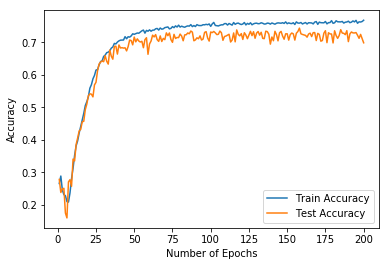

In [17]:
e = np.arange(1,num_epochs+1)
plt.plot(e,acc_train)
plt.plot(e,acc_test)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')

plt.show()

In [18]:
print("Maximum accuracy reached in the " , np.argmax(acc_test), "th epoch: %",np.amax(acc_test)*100)

Maximum accuracy reached in the  157 th epoch: % 74.3299999833107


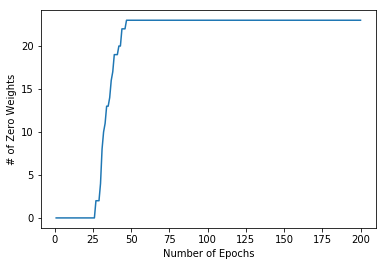

In [19]:
plt.plot(e,nonzero_weights)

plt.xlabel("Number of Epochs")
plt.ylabel("# of Zero Weights")

plt.show()